In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.plotting import autocorrelation_plot

# Caminho relativo para o CSV
script_dir = os.getcwd()
csv_path = os.path.join(script_dir, "../simple_prophet_forecast/Coffe_sales.csv")
csv_path = os.path.abspath(csv_path)

# Leitura
df = pd.read_csv(csv_path)
df.head()


,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


In [18]:
df.shape

(3547, 11)

In [19]:
# Padronizando em 'snake_case'
df.columns = df.columns.str.replace(' ', '_').str.lower()

print('hífens:', df['date'].str.contains('-').sum())
print('espaços:', df['date'].str.contains(' ').sum())


hífens: 3547
espaços: 0


In [20]:
# Agrupa por data e soma o valor de vendas
df_prophet = df.groupby('date')['money'].sum().reset_index()
df_prophet = df_prophet.rename(columns={'date': 'ds', 'money': 'y'})

# Conversão de data e reamostragem semanal
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='mixed')
df_weekly = df_prophet.resample('W-MON', on='ds').sum().reset_index()
df_weekly.head()


,ds,y
0,2024-03-04,1028.7
1,2024-03-11,1545.5
2,2024-03-18,1171.7
3,2024-03-25,1120.8
4,2024-04-01,1241.3


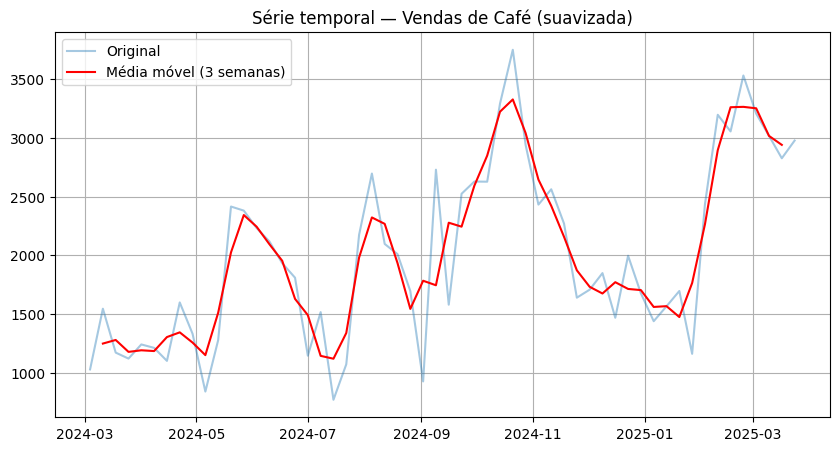

In [21]:
# Suavização para reduzir ruído
df_weekly['y_smooth'] = df_weekly['y'].rolling(3, center=True).mean()

plt.figure(figsize=(10, 5))
plt.plot(df_weekly['ds'], df_weekly['y'], label='Original', alpha=0.4)
plt.plot(df_weekly['ds'], df_weekly['y_smooth'], label='Média móvel (3 semanas)', color='red')
plt.title('Série temporal — Vendas de Café (suavizada)')
plt.legend()
plt.grid()
plt.show()


19:15:17 - cmdstanpy - INFO - Chain [1] start processing
19:15:17 - cmdstanpy - INFO - Chain [1] done processing


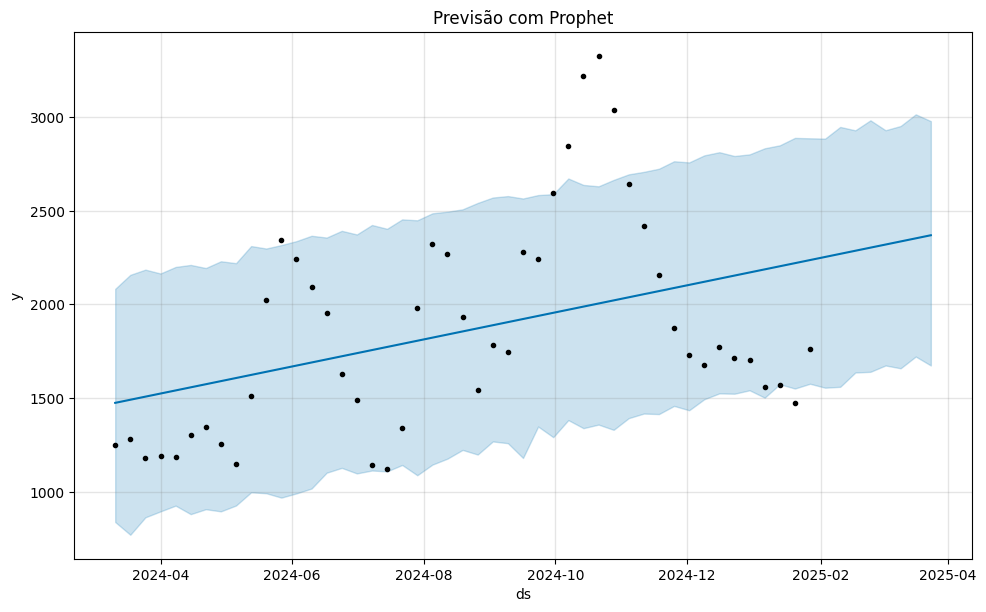

In [22]:
H = 8  # horizonte de teste (8 semanas)

train = df_weekly.iloc[:-H][['ds', 'y_smooth']].dropna().rename(columns={'y_smooth': 'y'})
test = df_weekly.iloc[-H:][['ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})

m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=H, freq='W-MON')
forecast = m.predict(future)

fig = m.plot(forecast)
plt.title("Previsão com Prophet")
plt.show()


MAE : 681.58
RMSE: 750.27
R²  : -4.214


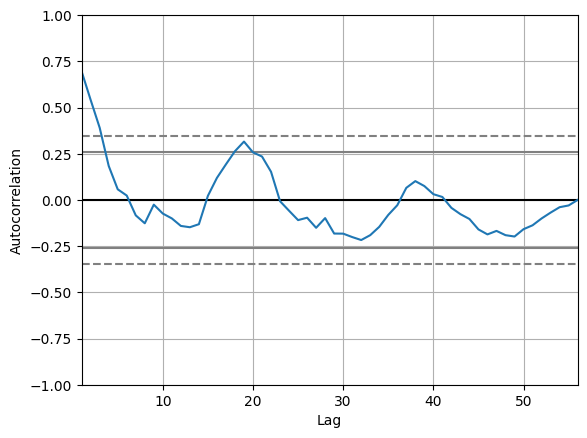

In [23]:
# Autocorrelação
autocorrelation_plot(df_weekly['y'])

# Métricas
eval_df = forecast[['ds', 'yhat']].merge(test, on='ds', how='right')
eval_df = eval_df.rename(columns={'y': 'y_true', 'yhat': 'y_pred'})
eval_df.dropna(inplace=True)

mae = mean_absolute_error(eval_df['y_true'], eval_df['y_pred'])
rmse = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))
r2 = r2_score(eval_df['y_true'], eval_df['y_pred'])

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")
